In [1]:
#Libraries needed for execution of code
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
cd "/kaggle/input/fog-or-smog-detection-dataset"

/kaggle/input/fog-or-smog-detection-dataset


In [3]:
# Set paths of the dataset
clear_images_path = '/kaggle/input/fog-or-smog-detection-dataset/Clear'
fog_images_path = '/kaggle/input/fog-or-smog-detection-dataset/foggy'

In [4]:
print("Number of Clear images:", len(os.listdir(clear_images_path)))
print("Number of Fog images:", len(os.listdir(fog_images_path)))



Number of Clear images: 1128
Number of Fog images: 1207


In [5]:
# Constant image size
img_width, img_height = 224, 224

In [6]:
# Function to read images and create numpy arrays
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_width, img_height))
        img_array = np.array(img)
        images.append(img_array)
        labels.append(label)
    return images, labels

In [7]:
from PIL import Image 


# Load safe and violent images
clear_images, clear_labels = load_images_from_folder(clear_images_path, 0)
fog_images, fog_labels = load_images_from_folder(fog_images_path, 1)

# Combine data
X = np.array(clear_images + fog_images)
y = np.array(clear_labels + fog_labels)

In [8]:
# Scale the images by 255
X = X / 255

In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
batch_size = 32

In [11]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split=0.3,
    fill_mode = 'nearest'
)

In [12]:
# Train and validation data generators

train_gen = data_gen.flow_from_directory(
    '/kaggle/input/fog-or-smog-detection-dataset',
    target_size = (img_width, img_height),
    batch_size = 16,
    class_mode = 'binary',
    subset = 'training'
)

Found 1635 images belonging to 2 classes.


In [13]:
val_gen = data_gen.flow_from_directory(
    '/kaggle/input/fog-or-smog-detection-dataset',
    target_size = (img_width, img_height),
    batch_size = 16,
    class_mode = 'binary',
    subset = 'validation'
)

Found 700 images belonging to 2 classes.


In [14]:
print(train_gen.samples)  # Check the number of samples loaded
print(train_gen.class_indices)  # Check the class indices mapping

print(val_gen.samples)  # Check the number of samples loaded
print(val_gen.class_indices)  # Check the class indices mapping

1635
{'Clear': 0, 'foggy': 1}
700
{'Clear': 0, 'foggy': 1}


In [15]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (img_width, img_height, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# adding custom layer on the top of pre trained model, because during loading model i exclude 'include_top'.

x = vgg16.output
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation = 'sigmoid')(x)

In [17]:
from tensorflow.keras.models import Model

model = Model(inputs = vgg16.input, outputs = predictions)

In [18]:
# freezing layers

for layer in vgg16.layers:
  layer.trainable = False

In [19]:
# compiling the model

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [20]:
# Correctly set steps_per_epoch and validation_steps
steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

In [21]:
# training the model

history = model.fit(
    train_gen,
    steps_per_epoch = steps_per_epoch,
    epochs = 30,
    validation_data = val_gen,
    validation_steps = validation_steps
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725981083.466264      82 service.cc:145] XLA service 0x782c8c004170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725981083.466334      82 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725981083.466346      82 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/51 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5000 - loss: 1.6742  

I0000 00:00:1725981093.536236      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - accuracy: 0.7748 - loss: 0.8700 - val_accuracy: 0.9286 - val_loss: 0.1572
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step - accuracy: 0.9407 - loss: 0.1683 - val_accuracy: 0.9315 - val_loss: 0.2404
Epoch 3/30
 1/51 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8750 - loss: 0.5217

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8750 - loss: 0.5217 - val_accuracy: 0.9643 - val_loss: 0.1099
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 445ms/step - accuracy: 0.9440 - loss: 0.1669 - val_accuracy: 0.8899 - val_loss: 0.2281
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - accuracy: 0.9334 - loss: 0.1603 - val_accuracy: 0.9405 - val_loss: 0.1634
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.8571 - val_loss: 0.2580
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 447ms/step - accuracy: 0.9332 - loss: 0.1722 - val_accuracy: 0.9315 - val_loss: 0.1449
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - accuracy: 0.9615 - loss: 0.1031 - val_accuracy: 0.9524 - val_loss: 0.1072
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.1333 - val_accuracy: 0.9643 - val_loss: 0.1297
Epoch 10/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 442ms/step - accuracy: 0.9486 - loss: 0.1319 - val_accuracy: 0.9345 - va

In [22]:
# Get the true labels and predictions
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred = np.round(y_pred).astype(int).flatten()  # Round predictions to get binary labels

44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 288ms/step


In [23]:
loss, accuracy = model.evaluate(val_gen)

print(f'Validation accuracy: {accuracy:.4f}')

44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.9707 - loss: 0.0601
Validation accuracy: 0.9629


In [24]:
model.save("/kaggle/working/save_model.keras")


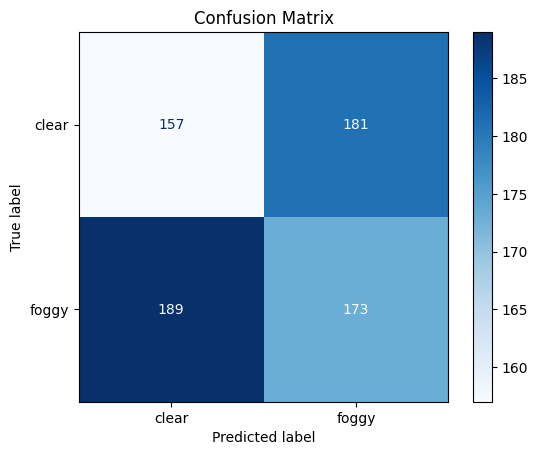

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = ["clear","foggy"])


#ploting the confusion matrix

cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Mobile V2 net


In [26]:
from tensorflow import keras

Mob_V2_Net=keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layers in Mob_V2_Net.layers:  # Freeze all Trainable Layers
  layers.trainable=False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
data_augmentation=keras.Sequential([
    keras.layers.RandomRotation(0.2), # RandomRotatiion
])

In [28]:
augment=data_augmentation(Mob_V2_Net.output) # First layer OF augmentation after PreTrained model layers
drop=keras.layers.Dropout(0.2)(augment)      # DropOut Layer to avoid overfitting
x=keras.layers.Flatten()(drop)               # Flatten Layer to flatten image
prediction=keras.layers.Dense(1,activation='sigmoid')(x) # Final Output Dense layer Having One Neuron and activation is sigmoid
model=keras.models.Model(inputs=Mob_V2_Net.input,outputs=prediction) # Define Model with input and output layer
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) # Compile Model | Optimizer : Adam
                                                                                                # loss : Binary Crossentropy (binary Classification)
                                                                                                # Metrics : Accuracy
model.summary() # Model Summary

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,320,705 (8.85 MB)

 Trainable params: 62,721 (245.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
model.fit(X_train,y_train,epochs=20)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8969 - loss: 0.3802
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9797 - loss: 0.0863
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9850 - loss: 0.0564
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9886 - loss: 0.0416
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9989 - loss: 0.0074
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9943 - loss: 0.0161
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9946 - loss: 0.0432
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9988 - loss: 0.0076
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9965 - loss: 0.0211
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9944 - loss: 0.0323
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9904 - loss: 0.1194
Epoch 12/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy

In [30]:
model.evaluate(X_val,y_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9789 - loss: 0.3518


[0.30695948004722595, 0.9828693866729736]

In [31]:
prediction=model.predict(X_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


In [32]:
threshold=0.5
preds=[]
for i in prediction:
  if(i>threshold):
    preds.append(1)
  else:
    preds.append(0)
preds[:10],y_val[:10]

([1, 1, 1, 0, 1, 0, 1, 0, 1, 1], array([1, 1, 1, 0, 1, 0, 1, 0, 1, 0]))

In [33]:
from sklearn.metrics import confusion_matrix as cm , classification_report as cr

print(cr(y_val,preds,target_names=['Clear','Foggy']))

              precision    recall  f1-score   support

       Clear       0.98      0.99      0.98       233
       Foggy       0.99      0.98      0.98       234

    accuracy                           0.98       467
   macro avg       0.98      0.98      0.98       467
weighted avg       0.98      0.98      0.98       467



<Axes: >

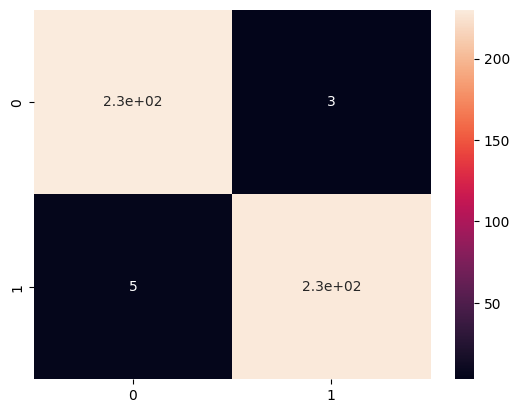

In [34]:
import seaborn as sns

cmm=(cm(y_val,preds))
sns.heatmap(cmm,annot=True)


In [35]:
model.save("/kaggle/working/mblnet model.keras")

In [36]:
model1=keras.models.load_model("/kaggle/working/mblnet model.keras")

In [37]:
import cv2

def prediction_function(file_path,model):
  classes=['Clear','Foggy']
  img=cv2.imread(file_path)
  resizee=cv2.resize(img,(224,224,))
  scale=resizee/255
  image=scale.reshape(1,224,224,3)
  prediction=model.predict(image)
  threshold=0.5
  pred=[1 if prediction>threshold else 0]
  plt.imshow(img)
  plt.title(classes[pred[0]])
  plt.axis("off")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


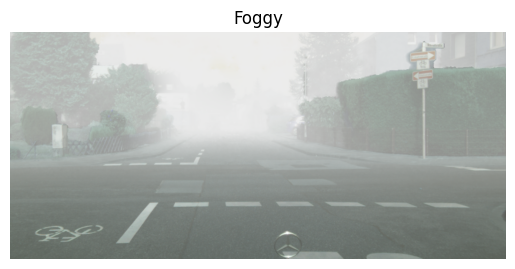

In [38]:
prediction_function("/kaggle/input/fog-or-smog-detection-dataset/foggy/Fog1 (122).png",model1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


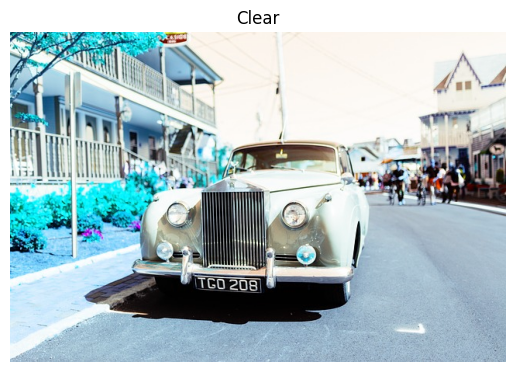

In [39]:
prediction_function('/kaggle/input/fog-or-smog-detection-dataset/Clear/clear (1057).jpg',model1)